In [1]:
#%pip install snowflake-connector-python
#%pip install python-dotenv

In [2]:
import pandas as pd
import numpy as np
import snowflake.connector as sf
from dotenv import load_dotenv
import os

In [3]:
# Do insert with Credentials in .env instead
load_dotenv()

# Connect to Snowflake
USER = os.getenv("SNOWFLAKE_USER")
PASSWORD = os.getenv("SNOWFLAKE_PASSWORD")
ACCOUNT = os.getenv("SNOWFLAKE_ACCOUNT")
WAREHOUSE = os.getenv("SNOWFLAKE_WAREHOUSE")
DATABASE = os.getenv("SNOWFLAKE_DATABASE")
SCHEMA = os.getenv("SNOWFLAKE_SCHEMA")
ROLE = os.getenv("SNOWFLAKE_ROLE")

In [4]:
ctx = sf.connect(
    user=USER,
    password=PASSWORD,
    account=ACCOUNT,
    warehouse=WAREHOUSE,
    database=DATABASE,
    schema=SCHEMA,
    role=ROLE,
    session_parameters={
        'QUERY_TAG': 'Panha Project Jupiter Notebook',
    }
)

In [5]:
# Select from Fact table: Date, PRODUCT_SKU, GROSS_SALES, NUMBER_OF_ORDERS, NUMBER_OF_CUSTOMERS, NUMBER_OF_UNITS_SOLD, CUSTOMER_SEGMENT?, COUNTRY, RETAIL_PRICE, DISCOUNT_RATE, COST_OF_GOODS_SOLD

In [6]:
def exec_query(query):
    cs = ctx.cursor()
    try:
        cs.execute(query)
        return cs.fetchall()
    finally:
        cs.close()

In [7]:
results = exec_query("SELECT * FROM LU_PRD_PRODUCT LIMIT 10")

for row in results:
    print(row)


(1, 'PART#000001', 13, 'Promo Burnished Copper', 'Chocolate', 7, 4, 7, Decimal('901.00'), 'ly. slyly ironi', 'B13_S7')
(2, 'PART#000002', 13, 'Large Brushed Brass', 'Yellow', 1, 3, 4, Decimal('902.00'), 'lar accounts amo', 'B13_S1')
(3, 'PART#000003', 42, 'Standard Polished Brass', 'Purple', 21, 99, 4, Decimal('903.00'), 'egular deposits hag', 'B42_S21')
(4, 'PART#000004', 34, 'Small Plated Brass', 'Green', 14, 2, 5, Decimal('904.00'), 'p furiously r', 'B34_S14')
(5, 'PART#000005', 32, 'Standard Polished Tin', 'Puff', 15, 1, 7, Decimal('905.00'), ' wake carefully ', 'B32_S15')
(6, 'PART#000006', 24, 'Promo Plated Steel', 'Forest', 4, 2, 1, Decimal('906.00'), 'sual a', 'B24_S4')
(7, 'PART#000007', 11, 'Small Plated Copper', 'Khaki', 45, 1, 1, Decimal('907.00'), 'lyly. ex', 'B11_S45')
(8, 'PART#000008', 44, 'Promo Burnished Tin', 'Snow', 41, 3, 5, Decimal('908.00'), 'eposi', 'B44_S41')
(9, 'PART#000009', 43, 'Small Burnished Steel', 'Dark', 12, 99, 4, Decimal('909.00'), 'ironic foxe', 'B

In [8]:
raw_data = exec_query("""
SELECT 
    FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE AS "DATE",
    LU_PRD_PRODUCT_SKU.PRODUCT_SKU_RETAIL_PRICE AS "RETAIL_RPICE",
    REL_CUS_SEGMENTATION_RFM.CLUSTER AS "CLUSTER",
    COUNT(DISTINCT(FACT_ORDER_LINE_ITEM_BASE.ORDER_CODE)) AS "NUM_ORDERS",
    SUM(FACT_ORDER_LINE_ITEM_BASE.ORDERED_QUANTITY) AS "UNIT_SOLD",
    AVG(FACT_ORDER_LINE_ITEM_BASE.DISCOUNT_RATE) AS "AVG_DISCOUNT_RATE",
    SUM(FACT_ORDER_LINE_ITEM_BASE.SUPPLY_UNIT_COST) AS "COGS",
FROM 
    LU_PRD_PRODUCT_SKU
JOIN 
    LU_PRD_PRODUCT
ON 
    LU_PRD_PRODUCT_SKU.PRODUCT_SKU = LU_PRD_PRODUCT.PRODUCT_SKU
JOIN 
    FACT_ORDER_LINE_ITEM_BASE 
ON 
    FACT_ORDER_LINE_ITEM_BASE.PRODUCT_CODE = LU_PRD_PRODUCT.PRODUCT_CODE
JOIN 
    LU_CUS_CUSTOMER 
ON
    LU_CUS_CUSTOMER.CUSTOMER_CODE = FACT_ORDER_LINE_ITEM_BASE.CUSTOMER_CODE
JOIN 
    REL_CUS_SEGMENTATION_RFM
ON
    REL_CUS_SEGMENTATION_RFM.CUSTOMER_CODE = FACT_ORDER_LINE_ITEM_BASE.CUSTOMER_CODE
WHERE
    LU_PRD_PRODUCT_SKU.PRODUCT_SKU IN  ('B33_S3')
    AND (YEAR(FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE) BETWEEN 2021 AND 2023)
GROUP BY
    DATE, RETAIL_RPICE, CLUSTER
ORDER BY
    DATE ASC
""")

In [9]:
# Convert raw_data to DataFrame
columns = ["DATE", "RETAIL_RPICE", "CLUSTER", "NUM_ORDERS", "UNIT_SOLD", "AVG_DISCOUNT_RATE", "COGS"]
df_raw_data = pd.DataFrame(raw_data, columns=columns)

We only take one product SKU come to study ```B15_S1```

1. Understand Structure of Dataset

In [10]:
df_raw_data.head()

,DATE,RETAIL_RPICE,CLUSTER,NUM_ORDERS,UNIT_SOLD,AVG_DISCOUNT_RATE,COGS
0,2021-01-01,1497.736864,2,1,30.00,0.08000000,917.30
1,2021-01-01,1497.736864,0,6,150.00,0.04000000,4058.74
2,2021-01-02,1497.736864,0,1,35.00,0.01000000,758.38
3,2021-01-02,1497.736864,1,3,105.00,0.05000000,749.34
4,2021-01-03,1497.736864,1,1,18.00,0E-8,387.60


Data Exploratory

In [11]:
df_raw_data.shape

(1575, 7)

In [12]:
df_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DATE               1575 non-null   object 
 1   RETAIL_RPICE       1575 non-null   float64
 2   CLUSTER            1575 non-null   int64  
 3   NUM_ORDERS         1575 non-null   int64  
 4   UNIT_SOLD          1575 non-null   object 
 5   AVG_DISCOUNT_RATE  1575 non-null   object 
 6   COGS               1575 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 86.3+ KB


In [13]:
# BEGIN: Convert data types
df_raw_data['UNIT_SOLD'] = df_raw_data['UNIT_SOLD'].astype(int)
df_raw_data['AVG_DISCOUNT_RATE'] = df_raw_data['AVG_DISCOUNT_RATE'].astype(float)
df_raw_data['COGS'] = df_raw_data['COGS'].astype(float)

2. Summarize Data

In [14]:
df_raw_data.describe()

,RETAIL_RPICE,CLUSTER,NUM_ORDERS,UNIT_SOLD,AVG_DISCOUNT_RATE,COGS
count,1.575000e+03,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000
mean,1.497737e+03,0.876825,1.506667,38.958730,0.050221,781.941562
std,2.274459e-13,0.804255,0.779209,27.392534,0.028555,534.425070
min,1.497737e+03,0.000000,1.000000,1.000000,0.000000,2.220000
25%,1.497737e+03,0.000000,1.000000,19.000000,0.030000,392.975000
50%,1.497737e+03,1.000000,1.000000,35.000000,0.050000,735.000000
75%,1.497737e+03,2.000000,2.000000,50.000000,0.070000,984.655000
max,1.497737e+03,2.000000,6.000000,175.000000,0.100000,4058.740000


In [15]:
df_raw_data['CLUSTER'].nunique()

3

3. Handle Missing Data

In [16]:
df_raw_data.isnull().sum()

DATE                 0
RETAIL_RPICE         0
CLUSTER              0
NUM_ORDERS           0
UNIT_SOLD            0
AVG_DISCOUNT_RATE    0
COGS                 0
dtype: int64

4. Outliers Detection

In [17]:
# %pip install seaborn

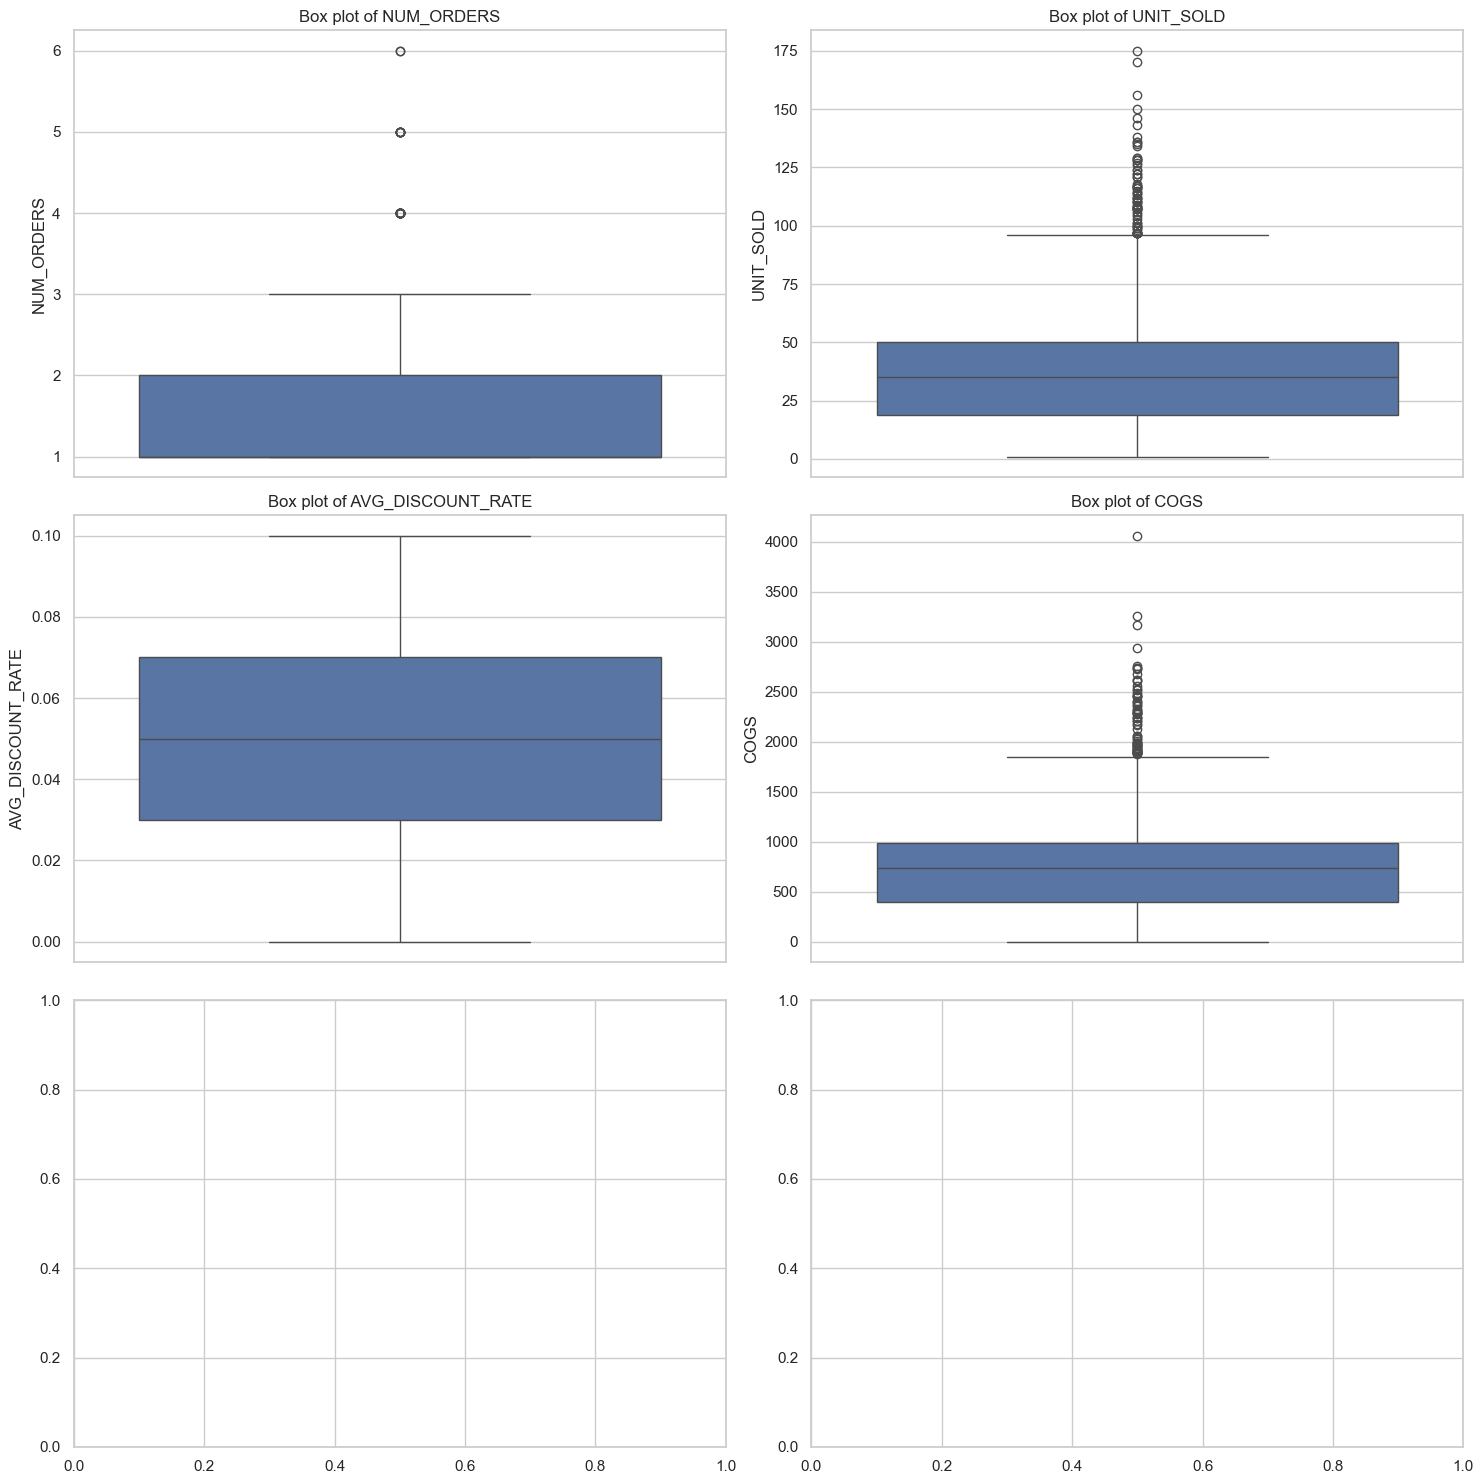

In [18]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure and axis
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# List of numerical columns to plot
numerical_columns = ['NUM_ORDERS', 'UNIT_SOLD', 'AVG_DISCOUNT_RATE', 'COGS']

# Plot each numerical column
for ax, column in zip(axes.flatten(), numerical_columns):
    sns.boxplot(y=df_raw_data[column], ax=ax)
    ax.set_title(f'Box plot of {column}')

# Adjust layout
plt.tight_layout()
plt.show()

In [19]:
# Calculate the percentage of outliers for each numerical column
outlier_percentages = {}

for column in numerical_columns:
    Q1 = df_raw_data[column].quantile(0.25)
    Q3 = df_raw_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_raw_data[(df_raw_data[column] < lower_bound) | (df_raw_data[column] > upper_bound)]
    outlier_percentage = (len(outliers) / len(df_raw_data)) * 100
    outlier_percentages[column] = outlier_percentage

outlier_percentages

{'NUM_ORDERS': 2.4761904761904763,
 'UNIT_SOLD': 4.444444444444445,
 'AVG_DISCOUNT_RATE': 0.0,
 'COGS': 4.444444444444445}

5. Understand the Distribution

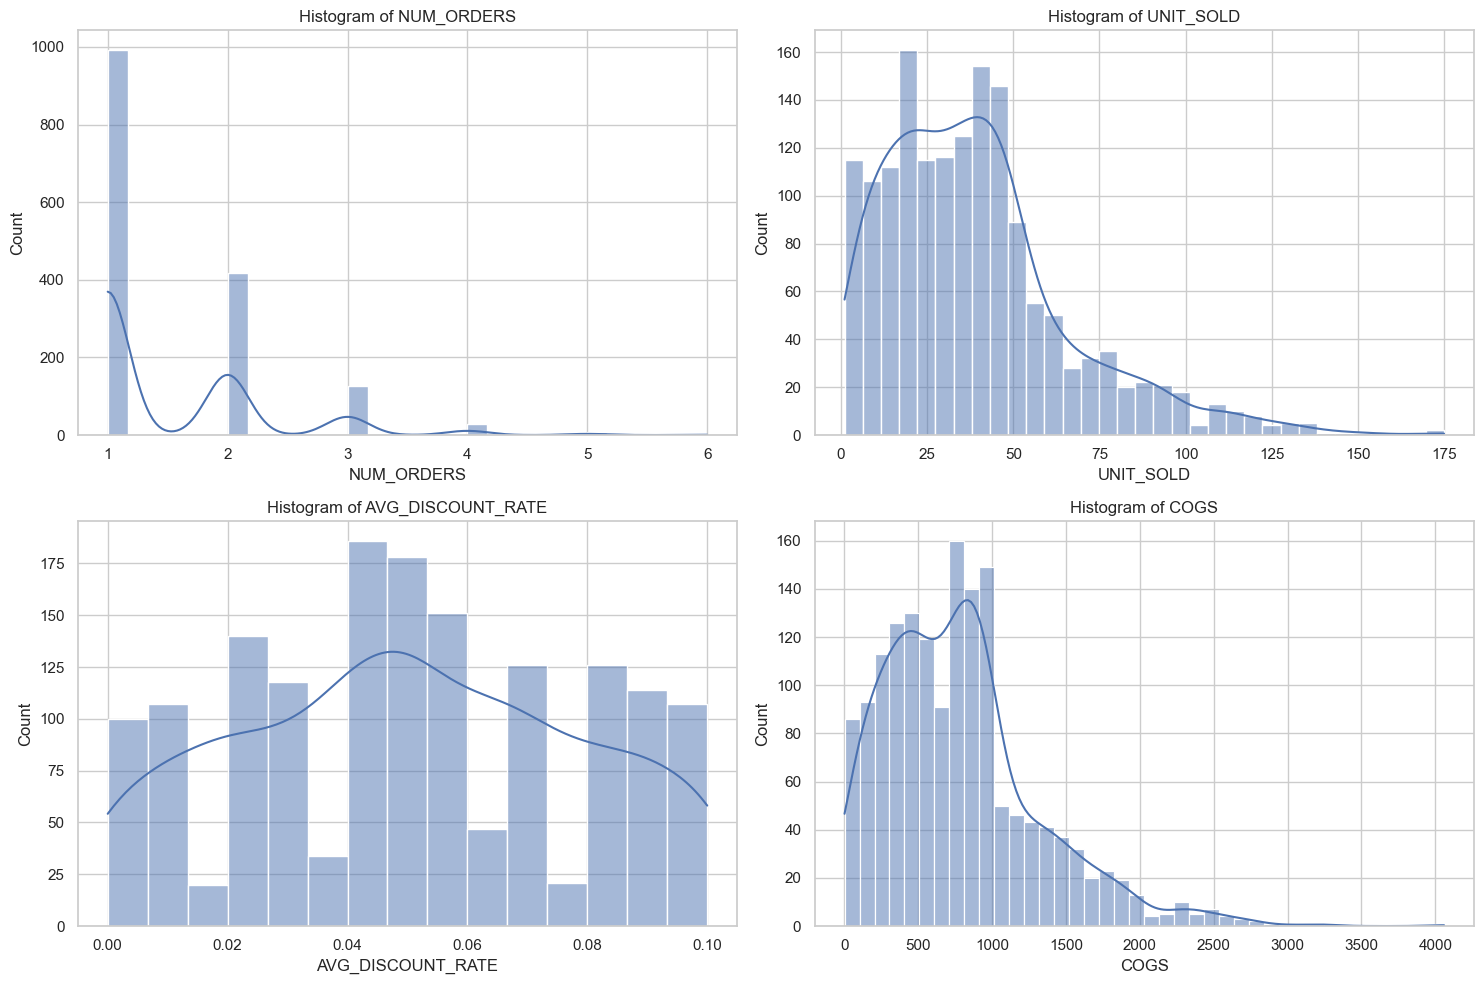

In [20]:
# Plot histograms for numeric features to understand their distribution
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot each numerical column
for ax, column in zip(axes.flatten(), numerical_columns):
    sns.histplot(df_raw_data[column], kde=True, ax=ax)
    ax.set_title(f'Histogram of {column}')

# Adjust layout
plt.tight_layout()
plt.show()

In [21]:
# Calculate skewness and kurtosis for each numerical column
skewness = df_raw_data[numerical_columns].skew()
kurtosis = df_raw_data[numerical_columns].kurt()

print("Skewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)

Skewness:
 NUM_ORDERS           1.764771
UNIT_SOLD            1.218976
AVG_DISCOUNT_RATE    0.009150
COGS                 1.189456
dtype: float64

Kurtosis:
 NUM_ORDERS           3.644543
UNIT_SOLD            1.902015
AVG_DISCOUNT_RATE   -0.965090
COGS                 2.219711
dtype: float64


In [22]:
# Convert DATE column to datetime
df_raw_data['DATE'] = pd.to_datetime(df_raw_data['DATE'])

# Encode DATE column to ordinal numbers
df_raw_data['DATE_ORDINAL'] = df_raw_data['DATE'].apply(lambda x: x.toordinal())

# Display the first few rows to verify the changes
df_raw_data.head()

,DATE,RETAIL_RPICE,CLUSTER,NUM_ORDERS,UNIT_SOLD,AVG_DISCOUNT_RATE,COGS,DATE_ORDINAL
0,2021-01-01,1497.736864,2,1,30,0.08,917.30,737791
1,2021-01-01,1497.736864,0,6,150,0.04,4058.74,737791
2,2021-01-02,1497.736864,0,1,35,0.01,758.38,737792
3,2021-01-02,1497.736864,1,3,105,0.05,749.34,737792
4,2021-01-03,1497.736864,1,1,18,0.00,387.60,737793


In [23]:
retail_price = df_raw_data['RETAIL_RPICE'][0]

6. Analyse relationship between variable

In [24]:
# Select all columns except 'RETAIL_RPICE'
df_selected = df_raw_data.drop(columns=['RETAIL_RPICE', 'DATE'])

# Display the first few rows to verify the changes
df_selected.head()

,CLUSTER,NUM_ORDERS,UNIT_SOLD,AVG_DISCOUNT_RATE,COGS,DATE_ORDINAL
0,2,1,30,0.08,917.30,737791
1,0,6,150,0.04,4058.74,737791
2,0,1,35,0.01,758.38,737792
3,1,3,105,0.05,749.34,737792
4,1,1,18,0.00,387.60,737793


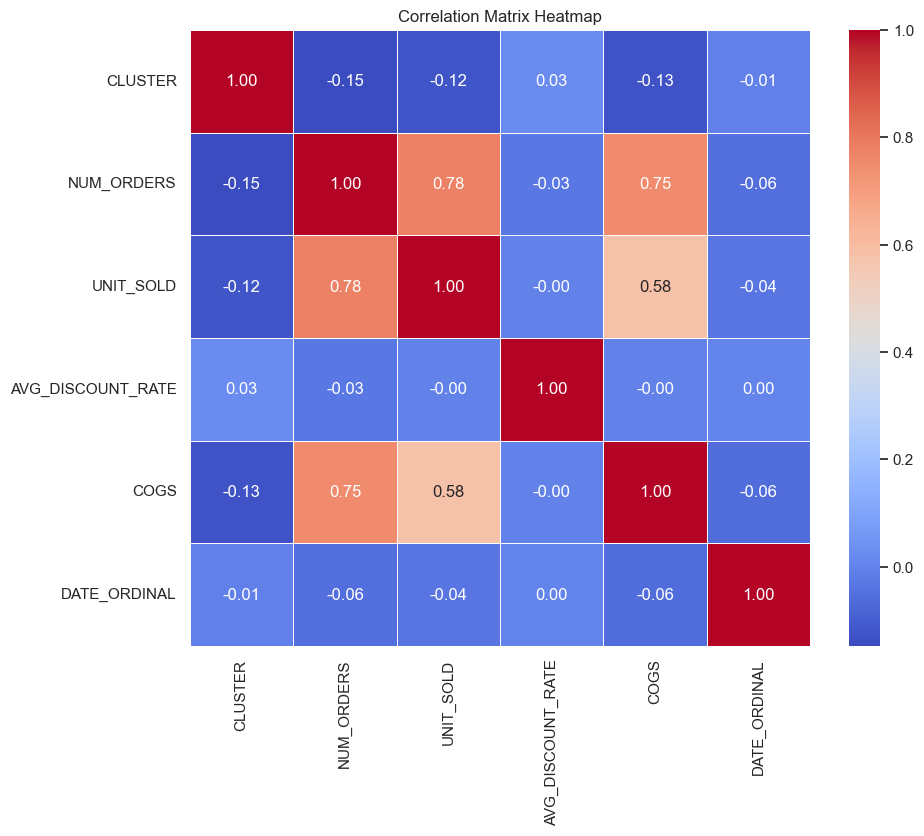

In [25]:
# Calculate the correlation matrix
corr_matrix = df_selected.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

7. Analyze Categorical Variables

Frequency Distribution of CLUSTER:
 CLUSTER
0    618
1    533
2    424
Name: count, dtype: int64


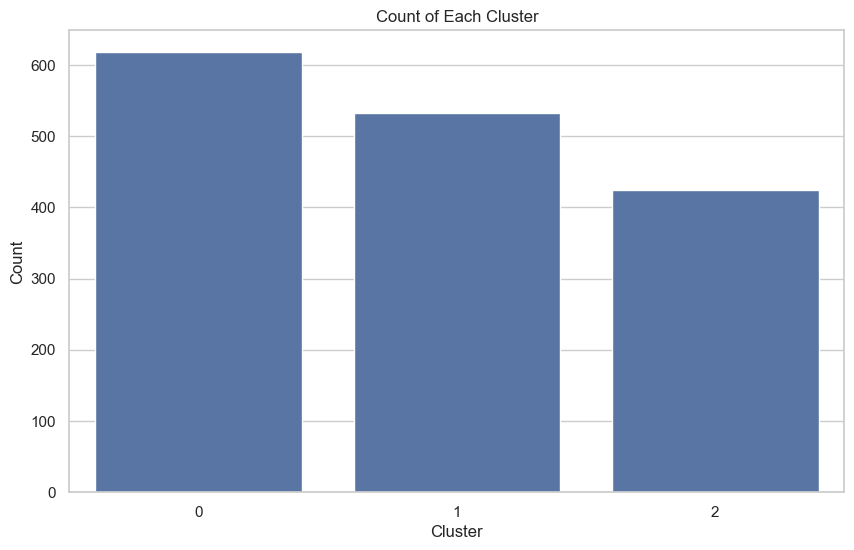

Cross-tabulation between CLUSTER and NUM_ORDERS:
 NUM_ORDERS    1    2   3   4  5  6
CLUSTER                           
0           347  185  63  16  5  2
1           340  136  46   8  3  0
2           306   96  17   5  0  0


In [26]:
# Frequency Distribution
cluster_counts = df_raw_data['CLUSTER'].value_counts()
print("Frequency Distribution of CLUSTER:\n", cluster_counts)

# Bar Plots
plt.figure(figsize=(10, 6))
sns.countplot(x='CLUSTER', data=df_raw_data)
plt.title('Count of Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Cross-tabulation
cross_tab = pd.crosstab(df_raw_data['CLUSTER'], df_raw_data['NUM_ORDERS'])
print("Cross-tabulation between CLUSTER and NUM_ORDERS:\n", cross_tab)

In [27]:
# Select the required columns for independent variables and target variable
df_model = df_raw_data[['DATE_ORDINAL', 'UNIT_SOLD', 'CLUSTER', 'AVG_DISCOUNT_RATE']]

# Display the first few rows to verify the changes
df_model.head()

,DATE_ORDINAL,UNIT_SOLD,CLUSTER,AVG_DISCOUNT_RATE
0,737791,30,2,0.08
1,737791,150,0,0.04
2,737792,35,0,0.01
3,737792,105,1,0.05
4,737793,18,1,0.00


In [28]:
# %pip install scikit-learn

In [29]:
from sklearn.model_selection import train_test_split

# Split the dataset into 80% training and 20% testing
train_set, test_set = train_test_split(df_model, test_size=0.2, random_state=42)

# Display the size of the training and testing sets
print(f"Training set size: {len(train_set)}")
print(f"Testing set size: {len(test_set)}")

Training set size: 1260
Testing set size: 315


In [30]:
# %pip install xgboost

In [56]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

X_train = train_set.drop(columns=['AVG_DISCOUNT_RATE'])
y_train = train_set['AVG_DISCOUNT_RATE']
X_test = test_set.drop(columns=['AVG_DISCOUNT_RATE'])
y_test = test_set['AVG_DISCOUNT_RATE']

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the XGBRegressor
xgb = XGBRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the model with the best parameters
best_xgb = XGBRegressor(**best_params)
best_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred = best_xgb.predict(X_test)

# Calculate the mean squared error
mse = np.mean((y_pred - y_test) ** 2)
print("Mean Squared Error: ", mse)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found:  {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Mean Squared Error:  0.0008068682479405384


In [32]:
X_train

,DATE_ORDINAL,UNIT_SOLD,CLUSTER
1043,738409,84,1
277,737961,32,2
1225,738510,43,2
1188,738493,43,0
1554,738723,9,1
...,...,...,...
1130,738454,6,2
1294,738552,48,2
860,738301,18,2
1459,738657,55,0


In [33]:
y_pred

array([0.04943859, 0.04940268, 0.04997324, 0.04938366, 0.04993844,
       0.04940268, 0.04947597, 0.04997819, 0.04934628, 0.04799225,
       0.04943859, 0.04997324, 0.04934628, 0.04940268, 0.04993733,
       0.04993733, 0.0499049 , 0.04969791, 0.04948737, 0.04948737,
       0.04993733, 0.05008721, 0.04902671, 0.04931037, 0.04940268,
       0.05001062, 0.04934628, 0.0499049 , 0.04934628, 0.04934628,
       0.04558281, 0.04993733, 0.04940268, 0.04940268, 0.04993733,
       0.04934628, 0.04940379, 0.04943859, 0.04940268, 0.04948737,
       0.05047546, 0.04943097, 0.04931037, 0.05002967, 0.04997324,
       0.04997324, 0.04943859, 0.04981259, 0.04993844, 0.04940268,
       0.0498485 , 0.04940268, 0.0499049 , 0.04947597, 0.04943859,
       0.05047757, 0.04934628, 0.05047546, 0.04993733, 0.0498485 ,
       0.04931148, 0.05043955, 0.04931037, 0.04940268, 0.04993733,
       0.04997324, 0.04947597, 0.05043955, 0.04940379, 0.04981259,
       0.04994081, 0.04994081, 0.05047546, 0.04931037, 0.04934

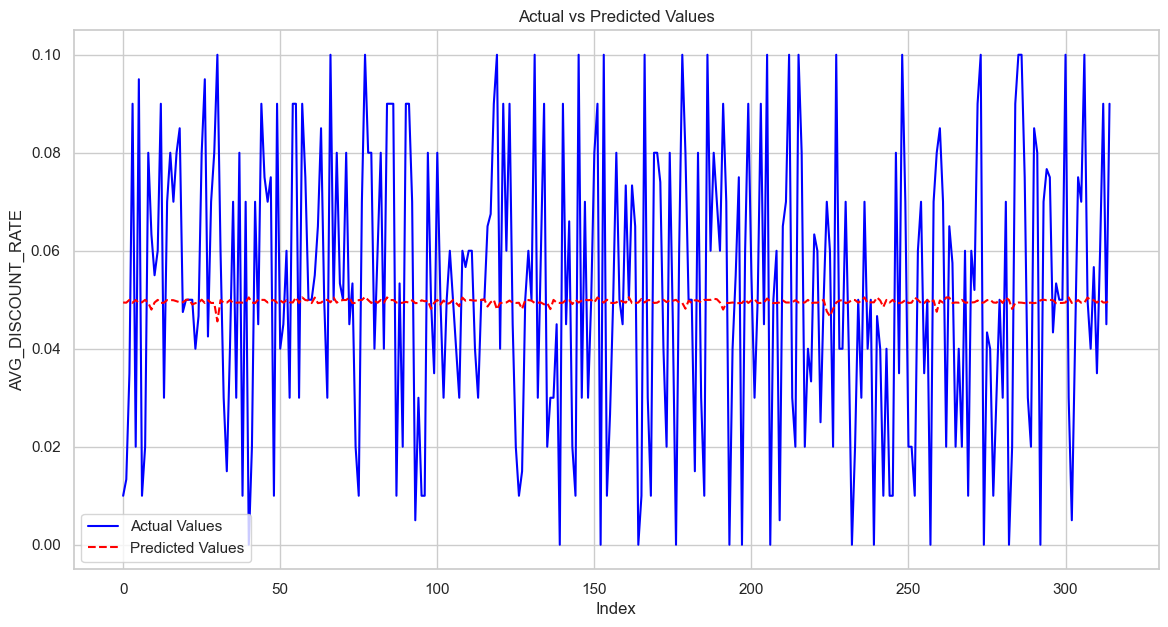

In [57]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(y_test.values, label='Actual Values', color='blue')

# Plot the predicted values
plt.plot(y_pred, label='Predicted Values', color='red', linestyle='dashed')

# Add title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('AVG_DISCOUNT_RATE')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [58]:
# Sample input data
sample_data = {
    'UNIT_SOLD': [200, 100, 150],
    'DATE': ['2023-09-01','2023-09-01','2023-09-01'],
    'CLUSTER': [0,1,2],
}

# Convert the sample input data to a DataFrame
df_sample = pd.DataFrame(sample_data)

# Convert DATE to ordinal
df_sample['DATE'] = pd.to_datetime(df_sample['DATE'])
df_sample['DATE_ORDINAL'] = df_sample['DATE'].apply(lambda x: x.toordinal())

# Drop the original DATE column
df_sample = df_sample.drop(columns=['DATE'])

# Predict using the trained model
# Reorder the columns of df_sample
df_sample = df_sample[['DATE_ORDINAL', 'UNIT_SOLD', 'CLUSTER']]

# Display the reordered DataFrame
df_sample
sample_prediction = best_xgb.predict(df_sample)

# Display the input and the predicted output
print("Sample Input:")
print(df_sample)
print("\nPredicted AVG_DISCOUNT_RATE:")
print(sample_prediction)

Sample Input:
   DATE_ORDINAL  UNIT_SOLD  CLUSTER
0        738764        200        0
1        738764        100        1
2        738764        150        2

Predicted AVG_DISCOUNT_RATE:
[0.05014364 0.049959   0.05067829]


,DATE_ORDINAL,UNIT_SOLD,CLUSTER
0,738764,50,1


In [53]:
df_sample

,DATE_ORDINAL,UNIT_SOLD,CLUSTER
0,738764,200,0
1,738764,100,1
2,738764,150,2


Sample Input:
   DATE_ORDINAL  UNIT_SOLD  CLUSTER
0        738764         50        1

Predicted AVG_DISCOUNT_RATE:
[0.049959]


In [50]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [61]:
from joblib import dump

# Save the model to a file
dump(best_xgb, 'models/best_xgb_model.joblib')

print("Model saved to 'best_xgb_model.joblib'")

Model saved to 'best_xgb_model.joblib'


In [62]:
from joblib import load

# Load the model from the file
loaded_model = load('models/best_xgb_model.joblib')

# Predict using the loaded model
sample_prediction_loaded = loaded_model.predict(df_sample)

# Display the input and the predicted output
print("Sample Input:")
print(df_sample)
print("\nPredicted AVG_DISCOUNT_RATE using loaded model:")
print(sample_prediction_loaded)

Sample Input:
   DATE_ORDINAL  UNIT_SOLD  CLUSTER
0        738764        200        0
1        738764        100        1
2        738764        150        2

Predicted AVG_DISCOUNT_RATE using loaded model:
[0.05014364 0.049959   0.05067829]
